<a href="https://colab.research.google.com/github/galenzo17/AI-personal-test/blob/main/really_bench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU disponible: NVIDIA A100-SXM4-40GB
Cargando modelo: gpt2
Cargando modelo: EleutherAI/gpt-neo-1.3B
Cargando modelo: facebook/opt-125m
Generando respuestas con el modelo: gpt2
Generando respuestas con el modelo: EleutherAI/gpt-neo-1.3B
Generando respuestas con el modelo: facebook/opt-125m

Tipos de datos de las columnas:
Modelo       object
Pregunta     object
BLEU        float64
ROUGE       float64
dtype: object

Métricas Generadas:
                     Modelo  \
0                      gpt2   
1                      gpt2   
2                      gpt2   
3                      gpt2   
4                      gpt2   
5   EleutherAI/gpt-neo-1.3B   
6   EleutherAI/gpt-neo-1.3B   
7   EleutherAI/gpt-neo-1.3B   
8   EleutherAI/gpt-neo-1.3B   
9   EleutherAI/gpt-neo-1.3B   
10        facebook/opt-125m   
11        facebook/opt-125m   
12        facebook/opt-125m   
13        facebook/opt-125m   
14        facebook/opt-125m   

                                             Pregunta      BLEU 

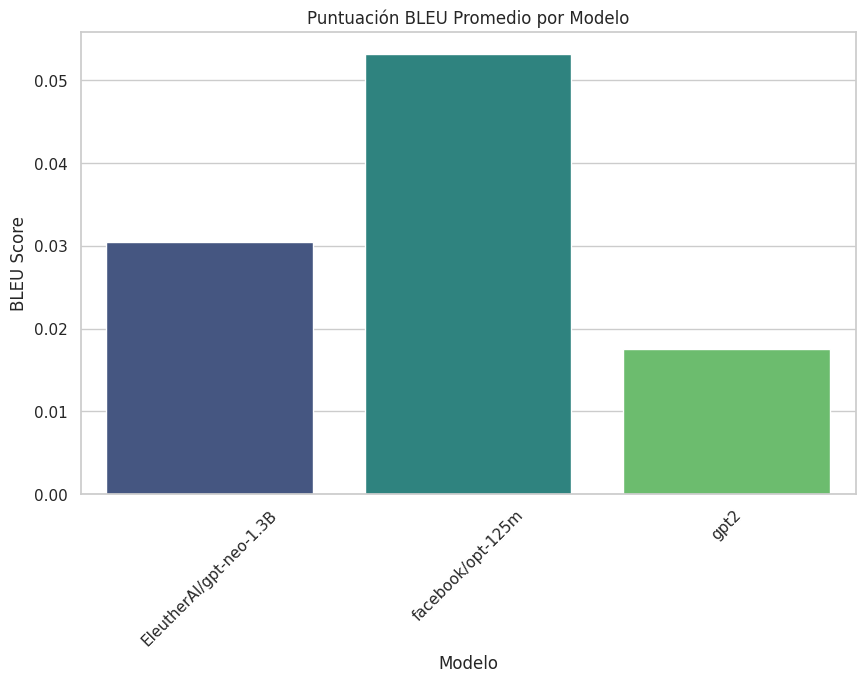

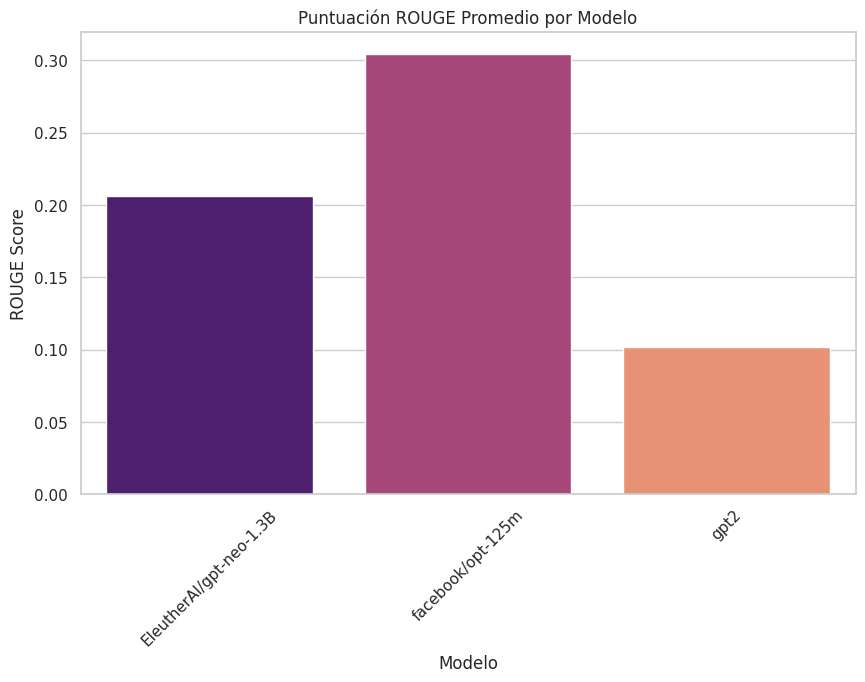

In [3]:
# Instalación de todas las bibliotecas necesarias en una sola línea
!pip install transformers datasets evaluate rouge_score

# Importación de bibliotecas
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from datasets import load_dataset
import evaluate
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Ignorar advertencias de deprecación para una salida más limpia
warnings.filterwarnings('ignore')

# Verificar si GPU está disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU no disponible, utilizando CPU.")

# Definición de modelos
model_names = [
    "gpt2",
    "EleutherAI/gpt-neo-1.3B",
    "facebook/opt-125m"
]

# Carga de modelos y tokenizadores con configuración de pad_token_id
models = {}
tokenizers = {}

for name in model_names:
    print(f"Cargando modelo: {name}")
    tokenizer = AutoTokenizer.from_pretrained(name)

    # Si el tokenizer no tiene definido pad_token, lo establecemos como eos_token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(name)

    # Asegurarse de que el modelo reconozca el pad_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    # Mover el modelo al dispositivo (GPU o CPU)
    model.to(device)

    models[name] = model
    tokenizers[name] = tokenizer

# Definición de preguntas
questions = [
    "¿Cuál es la capital de Francia?",
    "Explica la teoría de la relatividad de Einstein.",
    "¿Cuáles son los beneficios de la inteligencia artificial?",
    "Describe el proceso de fotosíntesis.",
    "¿Qué es el aprendizaje profundo?"
]

# Función para generar respuestas con attention_mask y max_new_tokens
def generate_response(model, tokenizer, prompt, max_new_tokens=100):
    with torch.no_grad():
        # Codificar el prompt sin padding excesivo
        inputs = tokenizer.encode_plus(
            prompt,
            return_tensors='pt',
            truncation=True,
            max_length=512  # Ajusta según tus necesidades y la capacidad del modelo
        )

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        # Generar la respuesta usando max_new_tokens
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,  # Especifica el número de tokens a generar
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id  # Asegurarse de que pad_token_id esté establecido
        )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response

# Generación de respuestas
responses = {}

for name in model_names:
    print(f"Generando respuestas con el modelo: {name}")
    responses[name] = []
    for question in questions:
        response = generate_response(models[name], tokenizers[name], question)
        responses[name].append(response)

# Respuestas de referencia
reference_answers = [
    "La capital de Francia es París.",
    "La teoría de la relatividad de Einstein describe la gravedad como una propiedad de la curvatura del espacio-tiempo.",
    "Los beneficios de la inteligencia artificial incluyen automatización, mejora en la toma de decisiones y avances en diversas industrias.",
    "La fotosíntesis es el proceso mediante el cual las plantas convierten la luz solar en energía química.",
    "El aprendizaje profundo es una subárea del aprendizaje automático que utiliza redes neuronales profundas para modelar y resolver problemas complejos."
]

# Evaluación de respuestas
bleu = evaluate.load('bleu')
rouge = evaluate.load('rouge')

metrics = []

for name in model_names:
    for i, question in enumerate(questions):
        generated = responses[name][i]
        reference = reference_answers[i]

        # Evaluar BLEU
        bleu_score = bleu.compute(predictions=[generated], references=[[reference]])['bleu']

        # Evaluar ROUGE
        rouge_score = rouge.compute(predictions=[generated], references=[reference])
        rouge_l = rouge_score['rougeL']  # Acceso directo al puntaje ROUGE-L F1

        # Añadir los resultados a la lista de métricas
        metrics.append({
            'Modelo': name,
            'Pregunta': question,
            'BLEU': bleu_score,
            'ROUGE': rouge_l
        })

# Crear un DataFrame a partir de las métricas
metrics_df = pd.DataFrame(metrics)

# Verificar los tipos de datos
print("\nTipos de datos de las columnas:")
print(metrics_df.dtypes)

# Asegurarse de que 'BLEU' y 'ROUGE' sean de tipo float
metrics_df['BLEU'] = metrics_df['BLEU'].astype(float)
metrics_df['ROUGE'] = metrics_df['ROUGE'].astype(float)

# Mostrar el DataFrame de métricas
print("\nMétricas Generadas:")
print(metrics_df)

# Calcular métricas promedio por modelo, especificando solo las columnas numéricas
average_metrics = metrics_df.groupby('Modelo')[['BLEU', 'ROUGE']].mean().reset_index()
print("\nMétricas Promedio por Modelo:")
print(average_metrics)

# Visualización de las métricas
sns.set(style="whitegrid")

# Gráfica BLEU
plt.figure(figsize=(10,6))
sns.barplot(x='Modelo', y='BLEU', data=average_metrics, palette='viridis')
plt.title('Puntuación BLEU Promedio por Modelo')
plt.ylabel('BLEU Score')
plt.xticks(rotation=45)
plt.show()

# Gráfica ROUGE
plt.figure(figsize=(10,6))
sns.barplot(x='Modelo', y='ROUGE', data=average_metrics, palette='magma')
plt.title('Puntuación ROUGE Promedio por Modelo')
plt.ylabel('ROUGE Score')
plt.xticks(rotation=45)
plt.show()
